# 1. Perkenalan
## Nama: Fahri Armand Rasyad
## Batch: RMT-035
## Objective: Membuat model machine learning dengan menganalisa gambar rambu lalu lintas untuk membantu keamanan lalu lintas dalam mendeteksi rambu lalu lintas dalam sistem aplikasi navigas (maps, google maps) dan membantu improve sistem monitor lalu lintas menjadi lebih akurat


# 2. Import Libraries

In [ ]:
import os
import cv2
import glob
import zipfile
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import shutil
import xml.etree.ElementTree as ET
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, Input
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

# 3. Data Load

In [ ]:
!kaggle datasets download -d andrewmvd/road-sign-detection

Dataset URL: https://www.kaggle.com/datasets/andrewmvd/road-sign-detection
License(s): CC0-1.0
 98% 213M/218M [00:00<00:00, 254MB/s]
100% 218M/218M [00:00<00:00, 240MB/s]


In [ ]:
# Unzip File
with zipfile.ZipFile('road-sign-detection.zip', 'r') as zip_ref:
    zip_ref.extractall('road-signs-data')

# Load images dan labels
data_dir = 'road-signs-data/'
image_paths = []
labels = []

for root, dirs, files in os.walk(data_dir):
    for file in files:
        if file.endswith(".xml"):
            image_paths.append(os.path.join(root, file))
            labels.append(os.path.basename(root))

# ubah menjadi dataframe
df = pd.DataFrame({
    'image_path': image_paths,
    'label': labels
})

print(f"Total images: {len(df)}")
print(df.head())

Total images: 877
                                image_path        label
0   road-signs-data/annotations/road99.xml  annotations
1  road-signs-data/annotations/road239.xml  annotations
2  road-signs-data/annotations/road794.xml  annotations
3   road-signs-data/annotations/road91.xml  annotations
4  road-signs-data/annotations/road843.xml  annotations


In [ ]:
# Paths untuk annotations dan images
main_path = '/content/road-signs-data'
annotations_path = os.path.join(main_path, 'annotations')
images_path = os.path.join(main_path, 'images')

# Function untuk parse XML annotations
def parse_annotation(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    boxes = []
    label = None

    for obj in root.iter('object'):
        label = obj.find('name').text
        for bbox in obj.findall('bndbox'):
            box = [
                int(bbox.find('xmin').text),
                int(bbox.find('ymin').text),
                int(bbox.find('xmax').text),
                int(bbox.find('ymax').text)
            ]
            boxes.append(box)

    return label, boxes

# Proses annotations untuk membuat DataFrame
data = []
for xml_file in os.listdir(annotations_path):
    if xml_file.endswith('.xml'):
        # Derive nama gambar dari XML filename
        image_name = os.path.splitext(xml_file)[0] + '.png'
        label, boxes = parse_annotation(os.path.join(annotations_path, xml_file))

        # mengecek apakah image ada
        image_path = os.path.join(images_path, image_name)
        if os.path.exists(image_path):
            for box in boxes:
                data.append({'Image_Name': image_name, 'Label': label, 'Bounding Box': box})
        else:
            print(f"Image not found: {image_path}")  # Debug message untuk missing images

# membuat dataframe
df = pd.DataFrame(data)

# menunjukkan 5 baris pertama
print(df.head())


    Image_Name       Label          Bounding Box
0   road99.png        stop    [41, 35, 222, 214]
1  road239.png  speedlimit  [176, 229, 185, 238]
2  road794.png  speedlimit  [101, 213, 163, 275]
3  road794.png  speedlimit    [19, 370, 32, 386]
4   road91.png        stop  [155, 243, 247, 358]


In [ ]:
# Define the paths for annotations and images
annotations_dir = '/content/road-signs-data/annotations'
images_dir = '/content/road-signs-data/images'
output_dir = '/content/road-signs-data/labeled_images'  # Directory output untuk data yang sudah dirapihkan

# Function untuk  parse PASCAL VOC XML annotations dan mengekstrak label
def get_label_from_annotation(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    # mendapatkan  label (class name) dari objek pertama di file annotations
    label = root.find('object').find('name').text
    return label

# Cmembuat output directory untuk setiap kelas
def create_label_directories(label_names):
    for label in label_names:
        label_dir = os.path.join(output_dir, label)
        if not os.path.exists(label_dir):
            os.makedirs(label_dir)

# Menempatkan gambar berdasarkan label
def organize_images_by_label(annotations_dir, images_dir):
    label_names = set()  # untuk unique label

    # Iterate setiap file annotation
    for xml_file in os.listdir(annotations_dir):
        if xml_file.endswith('.xml'):
            xml_path = os.path.join(annotations_dir, xml_file)

            # mendapatkan label dari XML annotation
            label = get_label_from_annotation(xml_path)
            label_names.add(label)

            # Corresponding image file
            image_file = xml_file.replace('.xml', '.png')
            image_path = os.path.join(images_dir, image_file)

            # membuat output directory jika label tidak ada
            label_dir = os.path.join(output_dir, label)
            if not os.path.exists(label_dir):
                os.makedirs(label_dir)

            # memindahkan image ke folder label masing-masing
            if os.path.exists(image_path):
                shutil.move(image_path, os.path.join(label_dir, image_file))
                print(f"Moved {image_file} to {label_dir}")
            else:
                print(f"Image {image_file} not found.")

    # memastikan semua directory label telah dibuat
    create_label_directories(label_names)

# function untuk mengorganisir images
organize_images_by_label(annotations_dir, images_dir)


Moved road99.png to /content/road-signs-data/labeled_images/stop
Moved road239.png to /content/road-signs-data/labeled_images/speedlimit
Moved road794.png to /content/road-signs-data/labeled_images/speedlimit
Moved road91.png to /content/road-signs-data/labeled_images/stop
Moved road843.png to /content/road-signs-data/labeled_images/speedlimit
Moved road222.png to /content/road-signs-data/labeled_images/speedlimit
Moved road742.png to /content/road-signs-data/labeled_images/speedlimit
Moved road646.png to /content/road-signs-data/labeled_images/speedlimit
Moved road145.png to /content/road-signs-data/labeled_images/crosswalk
Moved road591.png to /content/road-signs-data/labeled_images/speedlimit
Moved road840.png to /content/road-signs-data/labeled_images/speedlimit
Moved road92.png to /content/road-signs-data/labeled_images/stop
Moved road114.png to /content/road-signs-data/labeled_images/speedlimit
Moved road4.png to /content/road-signs-data/labeled_images/trafficlight
Moved road637.

In [ ]:
# Mengatur direktori dataset
data2_dir = '/content/road-signs-data/labeled_images'

# Mengecek nama kelas (ras kucing)
classes = os.listdir(data2_dir)
print("Classes:", classes)

# Mengecek jumlah gambar untuk setiap kelas
for class_name in classes:
    print(f"Jumlah gambar di kelas {class_name}: {len(os.listdir(os.path.join(data2_dir, class_name)))}")

# Mengecek ukuran dataset
total_images = sum(len(os.listdir(os.path.join(data2_dir, class_name))) for class_name in classes)
print(f"Total jumlah gambar di dataset: {total_images}")


Classes: ['speedlimit', 'stop', 'trafficlight', 'crosswalk']
Jumlah gambar di kelas speedlimit: 652
Jumlah gambar di kelas stop: 76
Jumlah gambar di kelas trafficlight: 61
Jumlah gambar di kelas crosswalk: 88
Total jumlah gambar di dataset: 877


In [ ]:
!pip install gdown

In [ ]:
# mendownload folder dengan directory yang sudah dirapihkan

# path folder
folder_path = "/content/road-signs-data"

# meng-zip folder
os.system(f"zip -r {folder_path}.zip {folder_path}")

# download folder
!gdown load {folder_path}.zip

print(f"Downloaded {folder_path}.zip to your Colab files.")

usage: gdown [-h] [-V] [-O OUTPUT] [-q] [--fuzzy] [--id] [--proxy PROXY] [--speed SPEED]
             [--no-cookies] [--no-check-certificate] [--continue] [--folder] [--remaining-ok]
             [--format FORMAT] [--user-agent USER_AGENT]
             url_or_id
gdown: error: unrecognized arguments: /content/road-signs-data.zip
Downloaded /content/road-signs-data.zip to your Colab files.


# 4. EDA

## 4.1 Distribusi Kelas dalam data

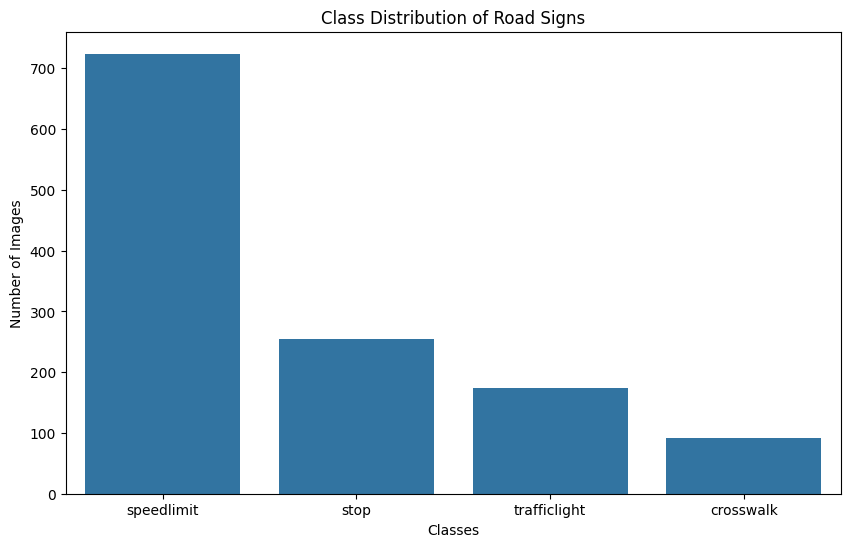

In [ ]:
# Class distribution
class_counts = df['Label'].value_counts()

# Visualisasi class distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=classes, y=class_counts)
plt.title('Class Distribution of Road Signs')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.show()



#### - Ditemukan bahwa gambar speedlimit paling banyak dalam data dan gambar crosswalk paling sedikit

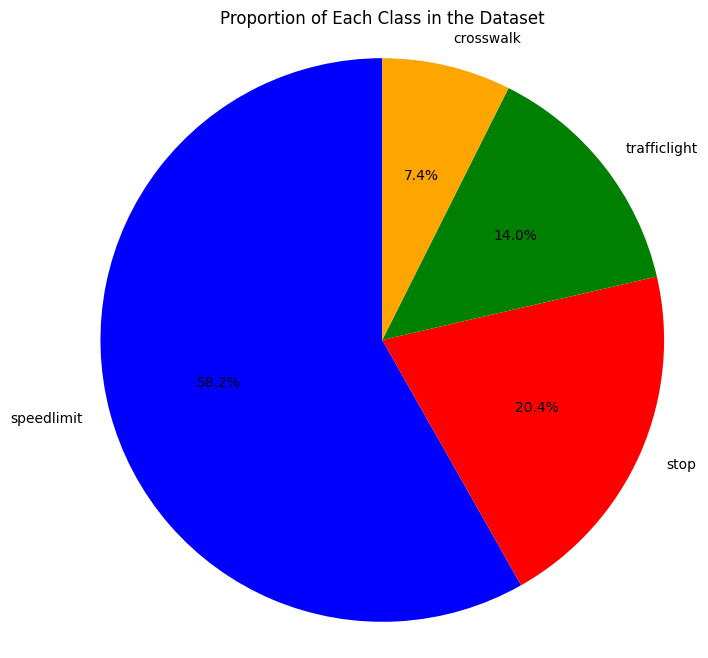

In [ ]:
# pie plot untuk melihat persentase dari setiap kelas terhadap total data
plt.figure(figsize=(8, 8))
plt.pie(class_counts, labels=classes, autopct='%1.1f%%', startangle=90, colors=['blue', 'red', 'green', 'orange'])
plt.title('Proportion of Each Class in the Dataset')
plt.axis('equal')
plt.show()

#### berikut merupakan pembagian kelas dari data

## 4.2 Contoh gambar dari setiap kelas

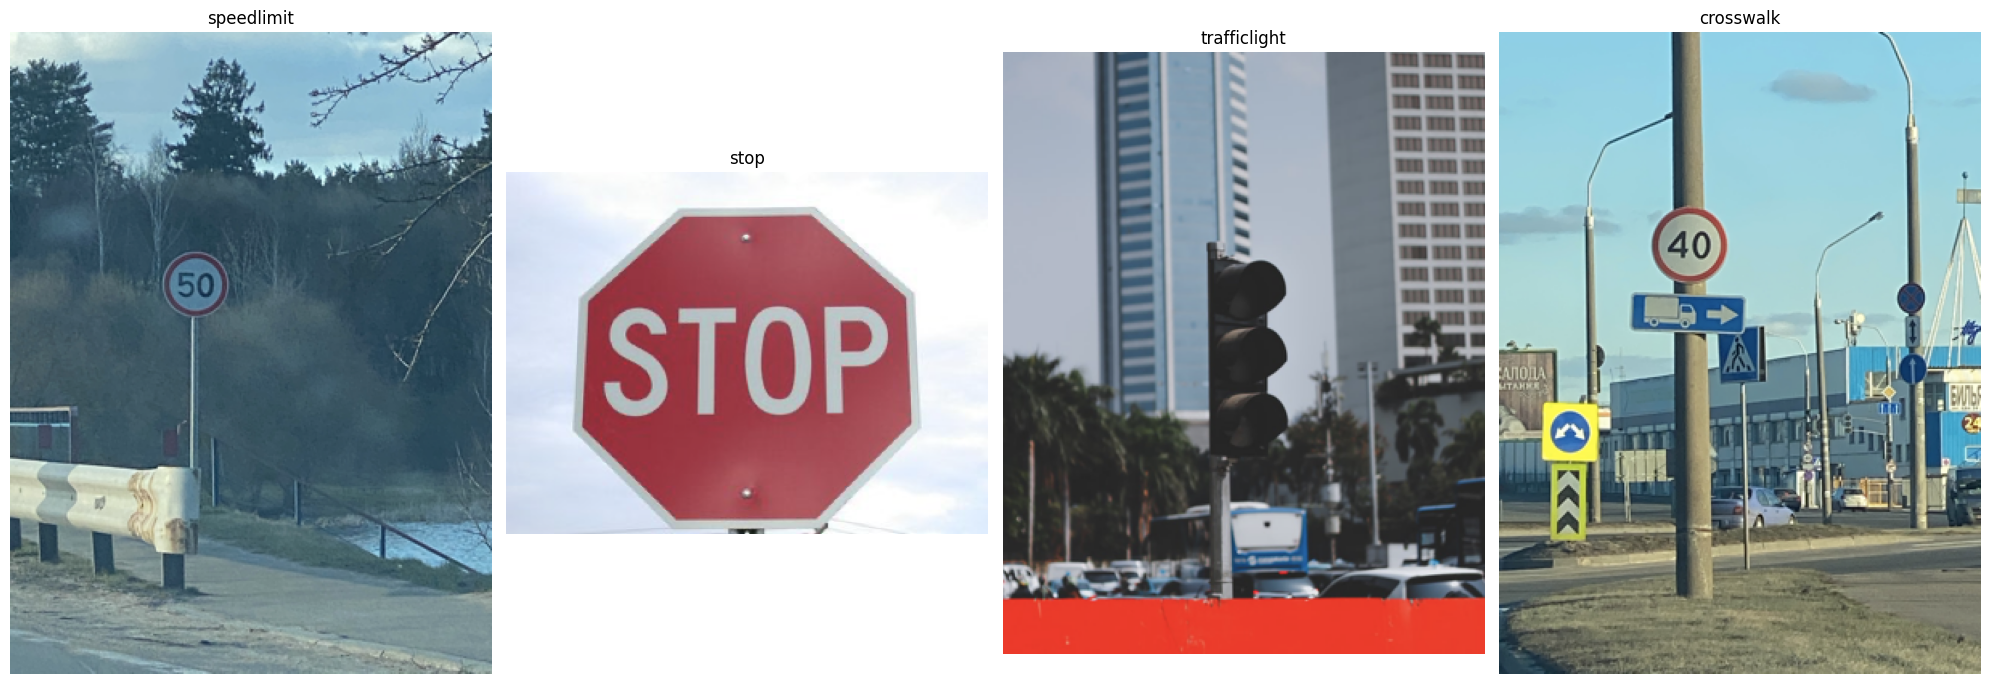

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(20, 10))

for i, class_name in enumerate(classes):
    image_path = os.path.join(data2_dir, class_name, os.listdir(os.path.join(data2_dir, class_name))[0])
    axes[i].imshow(Image.open(image_path))
    axes[i].set_title(class_name)
    axes[i].axis('off')

plt.tight_layout()
plt.show()


#### Berikut merupakan contoh gambar dari setiap kelas

# 5. Feature Engineering

In [ ]:

# Data Augmentation dan pembagian train-validation
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Data generator untuk training set
train_gen = datagen.flow_from_directory(
    data2_dir,                 # Direktori dataset
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

# Data generator untuk validation set
val_gen = datagen.flow_from_directory(
    data2_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 703 images belonging to 4 classes.
Found 174 images belonging to 4 classes.


# 6. ANN Training (Sequential API/Functional API)

## 6.1 Model Definition

In [ ]:
# Model Definition
model = Sequential()

# Konvolusi Lapisan 1
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Konvolusi Lapisan 2
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten untuk mengubah 2D menjadi 1D
model.add(Flatten())

# Fully Connected Layer
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

# Kompilasi Model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

####  - Menggunakan model Sequential untuk kesederhanaan,
#### - Hyperparameter:
####   - Learning rate: 0.001 untuk optimasi yang lebih baik,
####   - Dropout: 0.5 untuk menghindari overfitting.
#### - Metrics yang digunakan: accuracy, untuk mengukur seberapa baik model dalam mengklasifikasikan data.

## 6.2 Model Training

In [ ]:
# Model Training
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    steps_per_epoch=train_gen.samples // train_gen.batch_size,
    validation_steps=val_gen.samples // val_gen.batch_size
)

Epoch 1/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.5807 - loss: 3.0786 - val_accuracy: 0.7437 - val_loss: 0.9941
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.7419 - loss: 1.0363 - val_accuracy: 0.7857 - val_loss: 0.8430
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - accuracy: 0.7409 - loss: 0.9047 - val_accuracy: 0.7375 - val_loss: 0.9058
Epoch 4/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8125 - loss: 0.6391 - val_accuracy: 0.5714 - val_loss: 1.1530
Epoch 5/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.7730 - loss: 0.7057 - val_accuracy: 0.6812 - val_loss: 1.1128
Epoch 6/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7812 - loss: 0.7720 - val_accuracy: 0.6429 - val_loss: 1.2925
Epoch 7/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.7615 - loss: 0.7363 - val_accuracy: 0.7188 - val_loss: 1.0253
Epoch 8/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7188 - loss: 0.8188 - val_accuracy: 0.7857 - val_loss

## 6.3 Model Evaluation

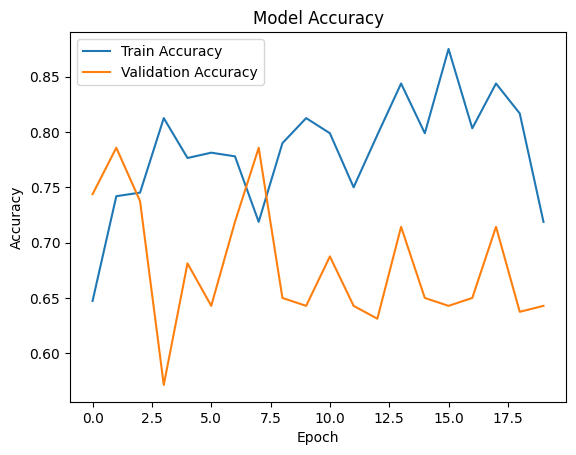

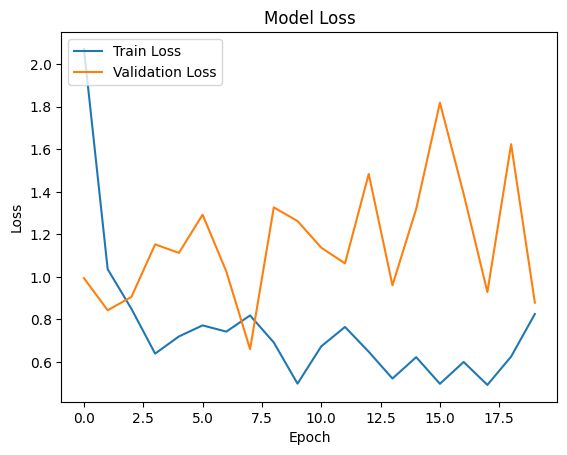

In [ ]:

# Model Evaluation
# Plotting Training & Validation Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plotting Training & Validation Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()



#### - Tren Umum: Grafik akurasi model menunjukkan fluktuasi yang cukup signifikan, terutama pada akurasi validasi. Terdapat beberapa puncak dan lembah yang mencolok, mengindikasikan ketidakstabilan dalam kinerja model selama pelatihan.
#### - Akurasi Pelatihan: Akurasi pelatihan secara umum meningkat hingga sekitar epoch ke-8, kemudian cenderung stagnan dengan sedikit fluktuasi. Setelah itu, terjadi penurunan yang cukup tajam. Pola ini menunjukkan bahwa model telah mempelajari pola dalam data pelatihan dengan baik hingga titik tertentu, namun kemudian mulai mengalami overfitting, di mana model terlalu menghafal noise dalam data pelatihan.
#### - Akurasi Validasi: Akurasi validasi menunjukkan tren yang lebih bervariasi dibandingkan dengan akurasi pelatihan. Terdapat beberapa puncak yang cukup tinggi, namun secara keseluruhan cenderung menurun setelah epoch ke-5. Ini mengindikasikan bahwa model tidak mampu menggeneralisasi dengan baik pada data yang belum pernah dilihat sebelumnya dan mengalami overfitting yang cukup signifikan.

#### - Tren Umum: Grafik loss model menunjukkan tren yang berlawanan dengan grafik akurasi. Secara umum, nilai loss menurun seiring dengan peningkatan epoch, namun terdapat beberapa lonjakan yang signifikan, terutama pada loss validasi.
#### - Loss Pelatihan: Loss pelatihan terus menurun secara signifikan hingga sekitar epoch ke-8, kemudian cenderung stagnan atau sedikit meningkat. Hal ini konsisten dengan tren akurasi pelatihan yang menunjukkan overfitting.
#### - Loss Validasi: Loss validasi menunjukkan fluktuasi yang cukup besar, dengan beberapa penurunan dan peningkatan yang tajam. Setelah epoch ke-5, loss validasi cenderung meningkat secara signifikan, menunjukkan bahwa model semakin kesulitan dalam membuat prediksi yang akurat pada data yang belum pernah dilihat sebelumnya.

# 7. ANN Improvement (Sequential API/Functional API)

## 7.1 Model Definition

In [ ]:
# Model Improvement

improved_model = Sequential()
improved_model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(150, 150, 3)))
improved_model.add(MaxPooling2D(pool_size=(2, 2)))
improved_model.add(Conv2D(128, (3, 3), activation='relu'))
improved_model.add(MaxPooling2D(pool_size=(2, 2)))
improved_model.add(Flatten())
improved_model.add(Dense(256, activation='relu'))
improved_model.add(Dropout(0.5))
improved_model.add(Dense(4, activation='softmax'))

improved_model.compile(optimizer=Adam(learning_rate=0.0005),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])


## 7.2 Model Training

In [ ]:
# Model Training (Improved Model)
improved_history = improved_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    steps_per_epoch=train_gen.samples // train_gen.batch_size,
    validation_steps=val_gen.samples // val_gen.batch_size
)




Epoch 1/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 87s 4s/step - accuracy: 0.5728 - loss: 2.5716 - val_accuracy: 0.6750 - val_loss: 1.0324
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.7812 - loss: 0.8890 - val_accuracy: 0.7857 - val_loss: 0.7116
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 83s 4s/step - accuracy: 0.7980 - loss: 0.6889 - val_accuracy: 0.6750 - val_loss: 1.0783
Epoch 4/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.8750 - loss: 0.4989 - val_accuracy: 0.7143 - val_loss: 0.9376
Epoch 5/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 139s 4s/step - accuracy: 0.7977 - loss: 0.6888 - val_accuracy: 0.6812 - val_loss: 1.0299
Epoch 6/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step - accuracy: 0.7188 - loss: 0.6778 - val_accuracy: 0.7143 - val_loss: 1.0638
Epoch 7/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 84s 4s/step - accuracy: 0.8121 - loss: 0.6018 - val_accuracy: 0.6812 - val_loss: 1.1354
Epoch 8/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.7812 - loss: 0.6561 - val_accuracy: 0.7857 - val

## 7.3 Model Evaluation

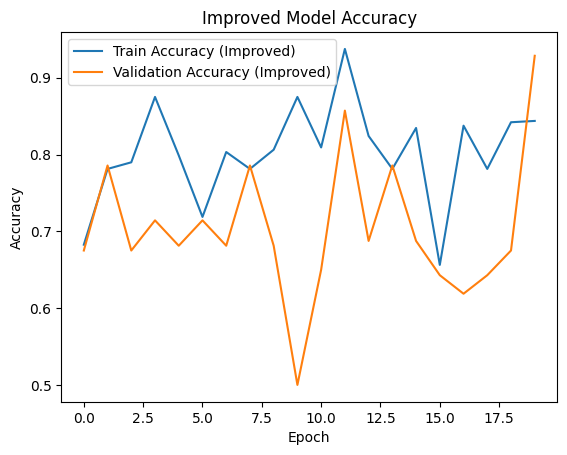

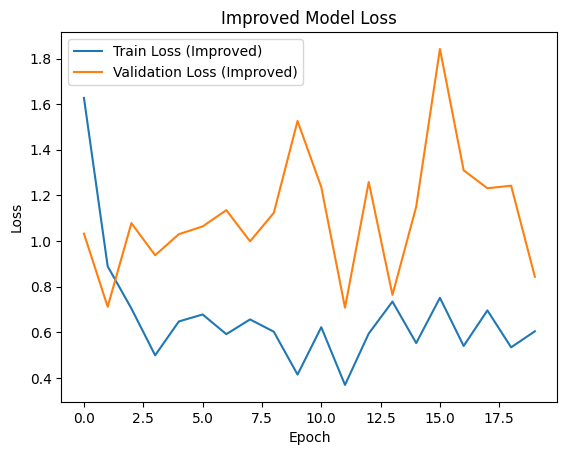

In [ ]:
# Model Evaluation (Improved Model)
plt.plot(improved_history.history['accuracy'], label='Train Accuracy (Improved)')
plt.plot(improved_history.history['val_accuracy'], label='Validation Accuracy (Improved)')
plt.title('Improved Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

plt.plot(improved_history.history['loss'], label='Train Loss (Improved)')
plt.plot(improved_history.history['val_loss'], label='Validation Loss (Improved)')
plt.title('Improved Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()




#### - Tren Umum: Grafik menunjukkan fluktuasi yang cukup signifikan, baik pada akurasi pelatihan maupun validasi. Ini mengindikasikan bahwa model masih mengalami beberapa ketidakstabilan dalam proses pembelajaran.
#### - Akurasi Pelatihan: Terdapat peningkatan yang signifikan pada beberapa titik, namun juga terdapat penurunan yang cukup tajam. Ini menandakan bahwa model telah belajar dengan baik dari data pelatihan, namun juga rentan terhadap overfitting, di mana model terlalu menghafal data pelatihan sehingga kurang mampu menggeneralisasi ke data baru.
#### - Akurasi Validasi: Secara umum, akurasi validasi menunjukkan peningkatan, namun tetap terdapat fluktuasi yang cukup besar. Peningkatan ini mengindikasikan bahwa perbaikan yang dilakukan telah membantu model dalam menggeneralisasi ke data yang belum pernah dilihat sebelumnya.

#### - Tren Umum: Nilai loss secara umum menurun, baik untuk pelatihan maupun validasi. Ini menunjukkan bahwa model semakin baik dalam meminimalkan kesalahan prediksi.
#### - Loss Pelatihan: Penurunan loss pelatihan menunjukkan bahwa model semakin mampu menyesuaikan diri dengan data pelatihan.
#### - Loss Validasi: Penurunan loss validasi juga menunjukkan peningkatan kinerja model pada data yang belum pernah dilihat sebelumnya.

# 8. Model Saving

In [24]:
model.save('best_model.h5')

In [26]:
improved_model.save('best_model.h5')

In [28]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
# Ensure the directory exists (create 'MyModel' folder if needed)
!mkdir -p /content/drive/MyDrive/MyModel

# Save the model to Google Drive
improved_model.save('/content/drive/MyDrive/MyModel/best_model.h5')


# 10. Kesimpulan

## 10.1 Model Analysis

### Overfitting: Model masih cenderung mengalami overfitting, terutama terlihat dari penurunan akurasi validasi setelah mencapai titik puncak.
### Stabilitas: Kinerja model masih cukup fluktuatif, baik dalam hal akurasi maupun loss.

## 10.2 Saran untuk Model

### Regularisasi: Tambahkan penalti pada kompleksitas model (misalnya, L1/L2 regularization) untuk mencegah overfitting.
### Data augmentation: Perbanyak data pelatihan dengan melakukan transformasi pada data yang ada (misalnya, rotasi, flip, atau scaling).
### Dropout: Secara acak nonaktifkan beberapa neuron selama pelatihan untuk mencegah co-adaptation antara neuron.
### Batch normalization: Normalisasi data pada setiap lapisan untuk mempercepat pelatihan dan meningkatkan stabilitas.
### Tuning hyperparameter: Sesuaikan hyperparameter seperti learning rate, jumlah hidden layer, atau jumlah neuron per layer untuk menemukan nilai optimal.
### Mencoba arsitektur model yang berbeda: coba menggunakan arsitektur model yang berbeda (misalnya, CNN, RNN)

## 10.3 Overall Analysis

#### -Didaptkan bahwa akurasi model dalam memprediksi data baru adalah 30%
#### -Rendahnya akurasi model dapat disebabkan karena model yang terlalu overfitting
#### -dapat disebabkan juga karena kurang tepatnya dalam feature engineering
#### -penyebab lain dari kurang akuratnya model dapat disebabkan karena dalam data training, mayoritas data (sekitar 58%) adalah speedlimit, ketidaksetaraan jumlah ini dapat menyebabkan model untuk tidak dapat memprediksi gambar dari kelas lain

#### - Kelebihan dari model ini adalah model cukup simple dan kelas juga tidak terlalu banyak
#### - kekurangan model ini adalah kurang tepatnya feature engineering yang menyebabkan model kurang akurat dalam menganalisa sebuah gambar
#### - Dengan hasil tersebut, disimpulkan bahwa model harus diimprove lagi karena dengan akurasi 30% sangat tidak pantas untuk digunakan dalam aplikasi navigasi maupun monitor lalu lintas
#### - saran untuk improvement adalah dengan menggunakan data untuk training dari setiap kelas yang lebih setara agar dapat membantu model dalam memprediksi gambar lebih akurat